<a href="https://colab.research.google.com/github/cxmedeiros/RedesNeurais/blob/main/classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧠 Classification Project: Neural Networks
##### Team: Kailane Felix (kefs), Gabriel Lopes (gls6), Camila Xavier (cxm), Luisa Mendes (mlmsp), Camila Siqueira (csl2)


#### 🌟 Experiment Results Summary:

| Model                                   | KS   | Accuracy | AUC   |
|-----------------------------------------|------|----------|-------|
| MLP without hyperparameter tuning       | 0.00 | 0.35     | 0.50  |
| Random Forest Classifier                | 0.23 | 0.59     | 0.62  |
| MLP Ensemble with 4 classifiers         | 0.21 | 0.64     | 0.59  |
| MLP Ensemble with 7 classifiers         | 0.28 | 0.64     | 0.64  |
| Heterogeneous Classifiers Ensemble      | 0.29 | 0.63     | 0.65  |
| MLP with hyperparameter tuning          | 0.28 | 0.62     | 0.63  |
| XGBoost                               | **0.30** | 0.65     | 0.65  |
| XGBoost Tuning                              | **0.32** | 0.66     | 0.66  |


The experiment results summary table presents key performance metrics for different models. Notably, **XGBoost Tuning stands out with the highest KS value of 0.32**, indicating its effectiveness in distinguishing between the two classes. Additionally, it achieves an AUC of 0.66, further confirming its strong predictive capability.

#### 📚 Importing the necessary libraries

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import shap
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 8, 5

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### 🔁 Conecting Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 🎲 Importing the data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Projetos de Redes Neurais/04. Projeto Final/01. Dados/TRAIN.xls', sep='\t')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Projetos de Redes Neurais/04. Projeto Final/01. Dados/TEST.cod', sep='\t')

#### 👀 Taking a look at the data

In [ ]:
train.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389196 entries, 0 to 389195
Columns: 246 entries, INDEX to IND_BOM_1_2
dtypes: float64(144), int64(102)
memory usage: 730.5 MB


In [ ]:
test.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.898745,1,...,0,1,1,1,0,0,0,0,1,0
1,1,1,1,0,1,0,0,0,0.847404,1,...,0,0,0,1,1,1,0,0,1,0
2,2,1,1,0,0,0,0,1,0.016513,0,...,0,1,0,0,1,0,0,1,0,1
3,3,1,1,0,1,0,0,0,0.688950,0,...,0,0,0,0,0,1,0,1,1,0
4,4,0,1,1,0,0,1,0,0.230114,1,...,0,1,0,0,1,0,1,0,1,0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129733 entries, 0 to 129732
Columns: 246 entries, INDEX to IND_BOM_1_2
dtypes: float64(144), int64(102)
memory usage: 243.5 MB


In [ ]:
train.drop(columns=['INDEX'], inplace=True)
test.drop(columns=['INDEX'], inplace=True)

#### ⚖️ Balancing the dataset through Random Oversampling of the minority class






⚙️ Checking the proportion among the target classes

Text(0.5, 1.0, 'Distribution of the target variable \n (0: Negative | 1: Positive))')

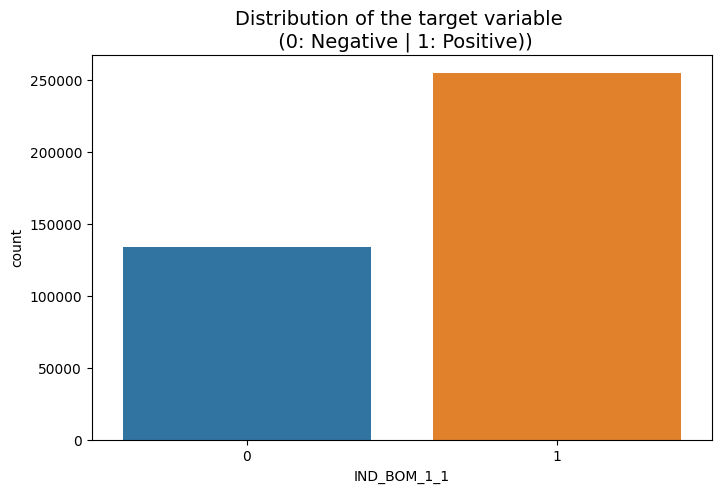

In [ ]:
sns.countplot(x='IND_BOM_1_1', data=train)
plt.title('Distribution of the target variable \n (0: Negative | 1: Positive))', fontsize=14)

In [ ]:
print('Percentage of 1 in the target class (training):', len(train[train['IND_BOM_1_1'] == 1])/len(train))
print('Percentage of 0 in the target class (training):', len(train[train['IND_BOM_1_1'] == 0])/len(train))

Percentage of 1 in the target class (training): 0.6554486685371895
Percentage of 0 in the target class (training): 0.34455133146281053


In [ ]:
print('Percentage of 1 in the target class (test):', len(test[test['IND_BOM_1_1'] == 1])/len(test))
print('Percentage of 0 in the target class (test):', len(test[test['IND_BOM_1_1'] == 0])/len(test))

Percentage of 1 in the target class (test): 0.655446185627404
Percentage of 0 in the target class (test): 0.344553814372596


⚙️ Splitting into training, testing, and validation

In [ ]:
X = train.drop(columns=['IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)
y = train['IND_BOM_1_1']

In [ ]:
X_test = test.drop(columns=['IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)
y_test = test['IND_BOM_1_1']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=1/3,
                                                  random_state=42)

In [ ]:
print('Proportion of the training dataset:', X_train.size / (X_train.size + X_test.size + X_val.size))
print('Proportion of the test dataset:', X_test.size / (X_train.size + X_test.size + X_val.size))
print('Proportion of the validation dataset', X_val.size / (X_train.size + X_test.size + X_val.size))

Proportion of the training dataset: 0.4999990364770518
Proportion of the test dataset: 0.25000144528442236
Proportion of the validation dataset 0.2499995182385259


In [ ]:
print('Percentage of 1 in the target class (y_train):', len(y_train[y_train.values == 1])/len(y_train))
print('Percentage of 0 in the target class (y_train):', len(y_train[y_train.values == 0])/len(y_train))

Percentage of 1 in the target class (y_train): 0.6548923935497796
Percentage of 0 in the target class (y_train): 0.3451076064502204


In [ ]:
print('Percentage of 1 in the target class (y_val):', len(y_val[y_val.values == 1])/len(y_val))
print('Percentage of 0 in the target class (y_val):', len(y_val[y_val.values == 0])/len(y_val))

Percentage of 1 in the target class (y_val): 0.6565612185120093
Percentage of 0 in the target class (y_val): 0.3434387814879906


In [ ]:
train = pd.concat([X_train, y_train])
val = pd.concat([X_val, y_val])

⚙️ Random Oversampling of the minority class

In [ ]:
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)
X_val, y_val = ros.fit_resample(X_val, y_val)

print('Proportion of classes in the training dataset: \n', pd.value_counts(pd.Series(y_train), normalize=True))
print('Proportion of classes in the validation dataset: \n', pd.value_counts(pd.Series(y_val), normalize=True))

Proportion of classes in the training dataset: 
 1    0.5
0    0.5
Name: IND_BOM_1_1, dtype: float64
Proportion of classes in the validation dataset: 
 0    0.5
1    0.5
Name: IND_BOM_1_1, dtype: float64


In [ ]:
print('Proportion of the training dataset:', X_train.size / (X_train.size + X_test.size + X_val.size))
print('Proportion of the test dataset:', X_test.size / (X_train.size + X_test.size + X_val.size))
print('Proportion of the validation dataset:', X_val.size / (X_train.size + X_test.size + X_val.size))

Proportion of the training dataset: 0.5310620396950286
Proportion of the test dataset: 0.2027303028929772
Proportion of the validation dataset: 0.26620765741199415


⚙️ Checking for any overlap between the test and validation sets

In [ ]:
merged_df = pd.merge(X_train, X_val, on='INDEX', how='inner')

if len(merged_df) > 0:
    print("There is overlap between the DataFrames")
else:
    print("There is no overlap between the DataFrames")

There is no overlap between the DataFrames


#### 📐 Metrics and evaluation

When evaluating classifiers, it's essential to use appropriate metrics to assess how well the model is performing its tasks. In this context, three commonly used metrics are KS (Kolmogorov-Smirnov), AUC (Area Under the Curve), and Accuracy.


##### **KS (Kolmogorov-Smirnov):**

KS is a metric that assesses a classifier's ability to separate two distinct classes, typically the positive class (e.g., "fraud") and the negative class (e.g., "non-fraud"). It's calculated as the maximum difference between two cumulative distribution functions: one for the positive class and another for the negative class. KS provides a value that indicates how effectively the model can distinguish between the two classes, with a higher value indicating better separation.

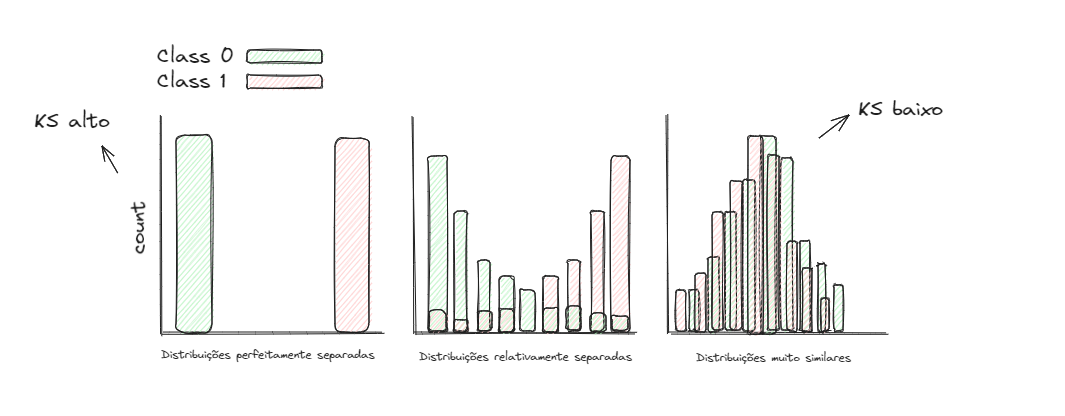

##### **AUC (Area Under the Curve):**

AUC is an evaluation metric representing the area under the Receiver Operating Characteristic (ROC) curve. The ROC curve is a plot that shows the true positive rate (sensitivity) against the false positive rate (1 - specificity) for different classification thresholds. A higher AUC signifies better model discrimination, where a value of 1 indicates perfect classification, and 0.5 indicates random guessing.

##### **Accuracy:**

Accuracy is a simple and widely used evaluation metric that measures the proportion of correct predictions made by the model compared to the total predictions. However, accuracy can be misleading when dealing with imbalanced datasets, where one class is much more prevalent than the other. In such cases, a model can achieve high accuracy simply by predicting the majority class all the time. Therefore, it's essential to consider other metrics like KS and AUC for a more comprehensive evaluation.

#### 1️⃣ MLP Classifier with simple parameters

##### 🏋️ Training...

Nesse primeiro momento vamos treinar a rede MLP em sua configuração padrão

In [ ]:
num_layers = 1
num_hidden_units = 20
activation_function = 'logistic'
learning_rate = 0.001

mlp_classifier = MLPClassifier(hidden_layer_sizes=(num_hidden_units,),
                               activation=activation_function,
                               learning_rate_init=learning_rate,
                               max_iter=1000)

clf = mlp_classifier.fit(X_train, y_train)

In [ ]:
mlp_predictions = clf.predict(X_test)

##### 🤔 Analyzing the model's classification report

In [ ]:
class_report = classification_report(y_test, mlp_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.34      1.00      0.51     44700
           1       0.73      0.00      0.00     85033

    accuracy                           0.35    129733
   macro avg       0.54      0.50      0.26    129733
weighted avg       0.60      0.35      0.18    129733



##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = mlp_classifier.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.0012
P-value: 1.0000
The distributions are not significantly different (fail to reject the null hypothesis).


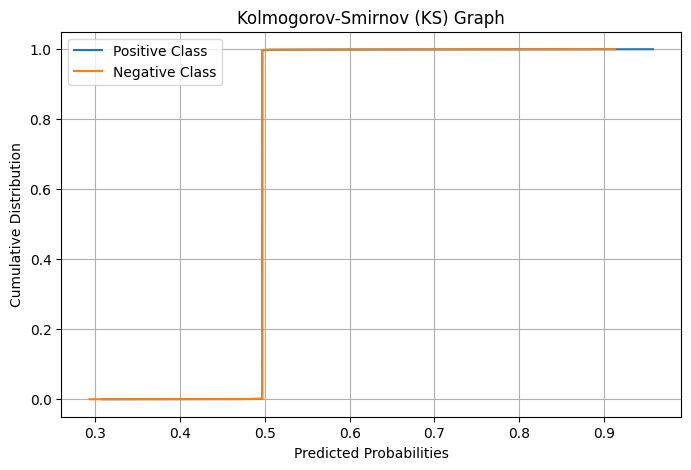

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

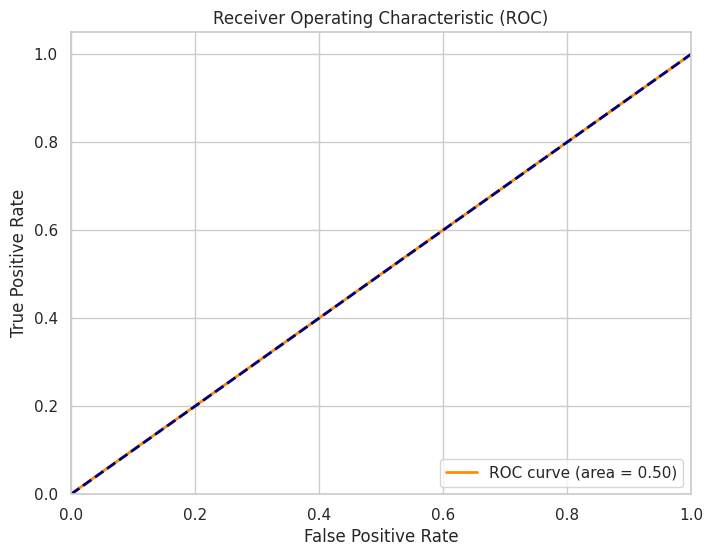

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, mlp_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 2️⃣ Random Forest Classifier

##### 🏋️ Training...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
max_depth = 4
min_samples_leaf = 1
min_samples_split = 24

random_forest_classifier = RandomForestClassifier(n_estimators=num_trees,
                                                  max_depth=max_depth,
                                                  min_samples_leaf=min_samples_leaf,
                                                  min_samples_split=min_samples_split,
                                                  random_state=42)

random_forest_classifier.fit(X_train, y_train)
rf_predictions = random_forest_classifier.predict(X_test)

##### 🤔 Analyzing the model's classification report

In [ ]:
class_report = classification_report(y_test, rf_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.44      0.70      0.54     44700
           1       0.77      0.53      0.63     85033

    accuracy                           0.59    129733
   macro avg       0.61      0.62      0.59    129733
weighted avg       0.66      0.59      0.60    129733



##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = random_forest_classifier.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.2348
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


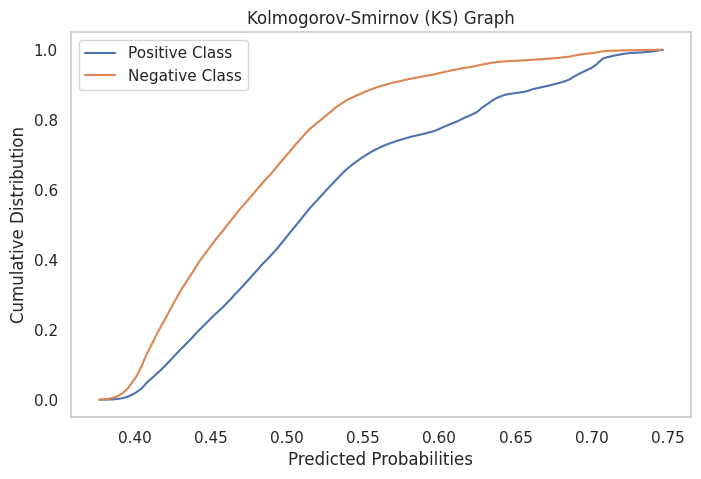

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

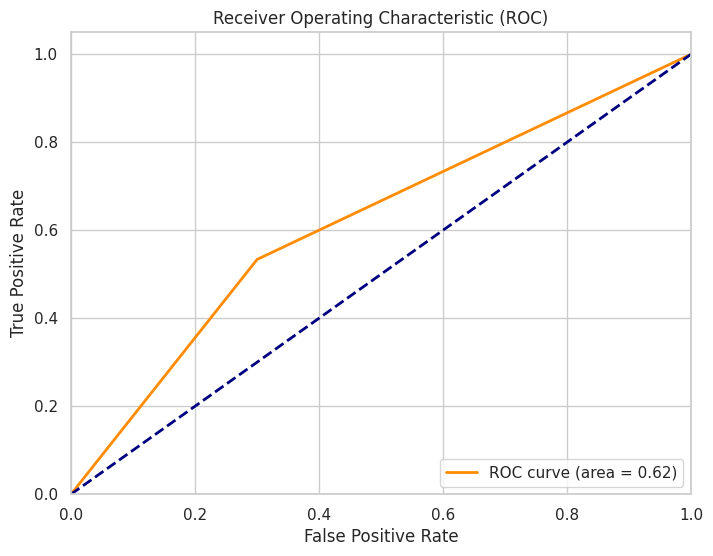

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, rf_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 3️⃣ MLP Ensemble (4 MLPs)

##### 🏋️ Training...

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

mlp1 = MLPClassifier(hidden_layer_sizes=[32, 16], activation='relu', learning_rate_init=0.001)
mlp2 = MLPClassifier(hidden_layer_sizes=[64, 32, 16], activation='logistic', learning_rate_init=0.01)
mlp3 = MLPClassifier(hidden_layer_sizes=[128], activation='tanh', learning_rate_init=0.0005)
mlp4 = MLPClassifier(hidden_layer_sizes=[64, 64], activation='relu', learning_rate_init=0.0001)

ensemble = VotingClassifier(estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3), ('mlp4', mlp4)],
                            voting='soft')

ensemble.fit(X_train, y_train)

ensemble_predictions = ensemble.predict(X_test)

accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {accuracy:.4f}")

Ensemble Accuracy: 0.6487


##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = ensemble.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.2107
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


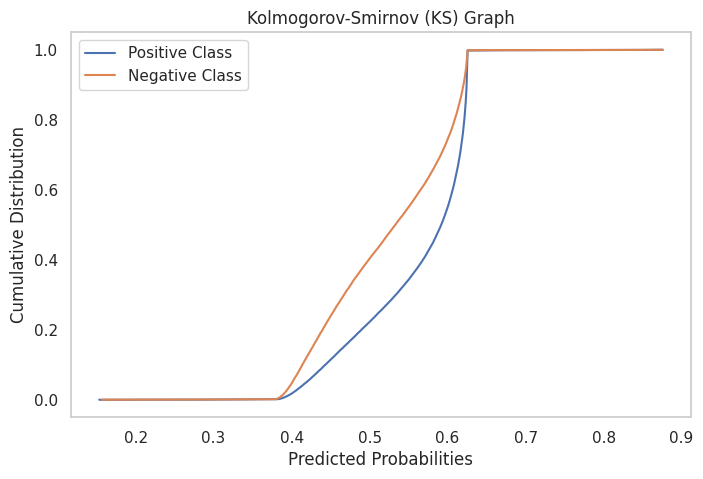

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

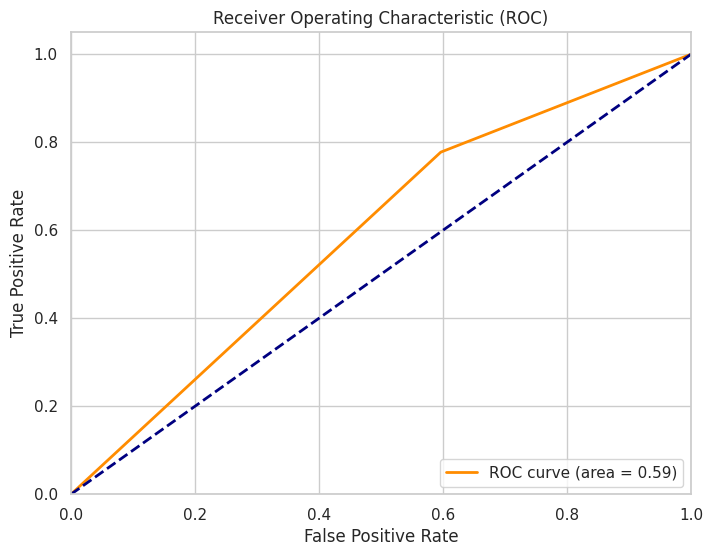

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 3️⃣.1️⃣ MLP Ensemble (7 MLPs)

##### 🏋️ Training...

In [ ]:
from sklearn.ensemble import VotingClassifier

# Define MLPClassifiers
mlp1 = MLPClassifier(hidden_layer_sizes=[32, 16], activation='relu', learning_rate_init=0.001)
mlp2 = MLPClassifier(hidden_layer_sizes=[64, 32, 16], activation='logistic', learning_rate_init=0.01)
mlp3 = MLPClassifier(hidden_layer_sizes=[128], activation='tanh', learning_rate_init=0.0005)
mlp4 = MLPClassifier(hidden_layer_sizes=[64, 64], activation='relu', learning_rate_init=0.0001)
mlp5 = MLPClassifier(hidden_layer_sizes=[64, 32], activation='logistic', learning_rate_init=0.001)
mlp6 = MLPClassifier(hidden_layer_sizes=[128, 64, 32], activation='relu', learning_rate_init=0.001)
mlp7 = MLPClassifier(hidden_layer_sizes=[32], activation='tanh', learning_rate_init=0.001)

# Create a VotingClassifier with all MLPClassifiers
ensemble = VotingClassifier(
    estimators=[
        ('mlp1', mlp1),
        ('mlp2', mlp2),
        ('mlp3', mlp3),
        ('mlp4', mlp4),
        ('mlp5', mlp5),
        ('mlp6', mlp6),
        ('mlp7', mlp7),
    ],
    voting='soft'
)

# Fit the ensemble on the training data
ensemble.fit(X_train, y_train)

# Make predictions using the ensemble
ensemble_predictions = ensemble.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {accuracy:.4f}")

Ensemble Accuracy: 0.6443


##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = ensemble.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.2801
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


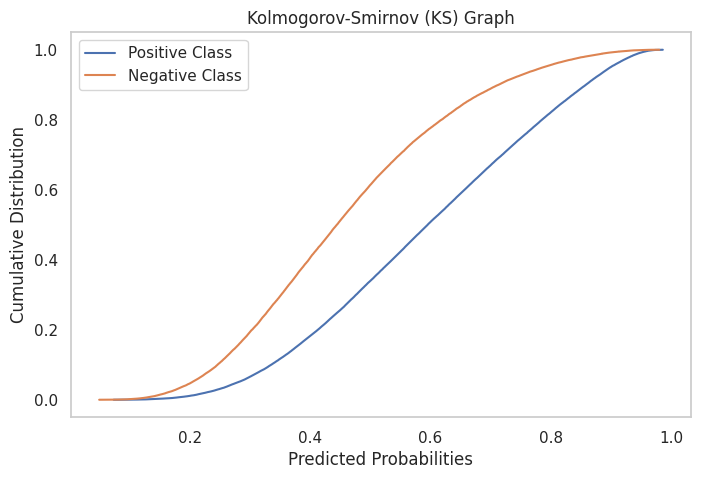

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

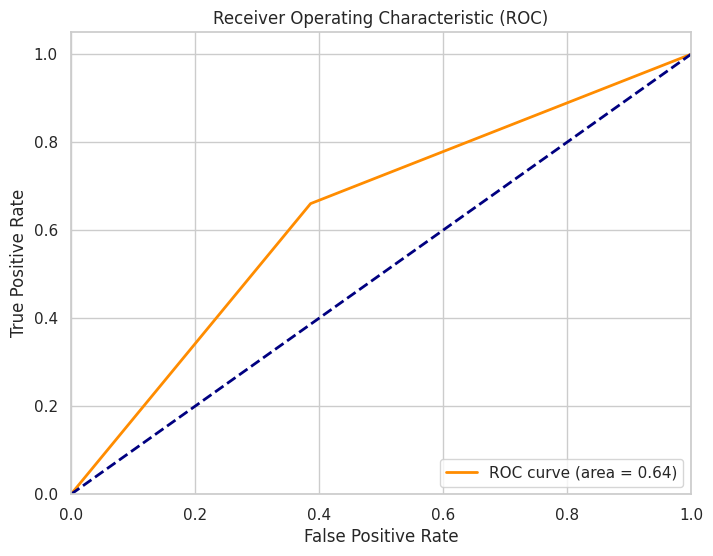

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 4️⃣ Classifiers Ensemble

##### 🏋️ Training...

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', learning_rate_init=0.001, random_state=42)
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=1, random_state=42)
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, min_samples_leaf=1, random_state=42)

ensemble_clf = VotingClassifier(estimators=[
    ('MLP', mlp_classifier),
    ('RandomForest', random_forest_classifier),
    ('GradientBoosting', gradient_boosting_classifier)
], voting='soft')

ensemble_clf.fit(X_train, y_train)

ensemble_clf_predictions = ensemble_clf.predict(X_test)

accuracy = accuracy_score(y_test, ensemble_clf_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6377714228453825


##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = ensemble_clf.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.2983
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


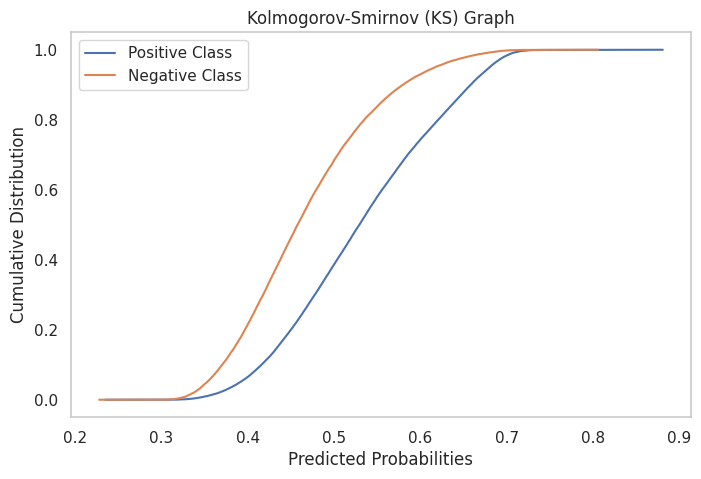

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

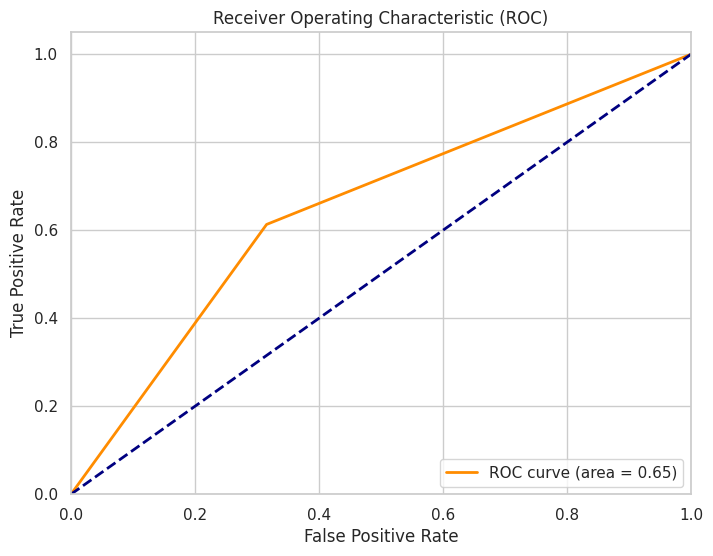

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, ensemble_clf_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 5️⃣ MLP Fine Tuning with Optuna



##### Defining parameter space

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(5,), (10, 30, 10), (20, 20), (50, 50, 50)],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.2, 0.5, 0.7],
    'batch_size': [16, 32, 64, 128],
    'epochs': [50, 100, 200],
    'early_stopping': [True, False],
    'patience': (20,),
}

##### 🔹Defining the objective function

In [ ]:
X_train.shape

(339842, 243)

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters from the parameter space
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', parameter_space['hidden_layer_sizes'])
    activation = trial.suggest_categorical('activation', parameter_space['activation'])
    optimizer_name = trial.suggest_categorical('optimizer', parameter_space['optimizer'])
    learning_rate = trial.suggest_float('learning_rate', parameter_space['learning_rate'][0], parameter_space['learning_rate'][2], log=True)
    dropout_rate = trial.suggest_float('dropout_rate', parameter_space['dropout_rate'][0], parameter_space['dropout_rate'][2])
    batch_size = trial.suggest_categorical('batch_size', parameter_space['batch_size'])
    epochs = trial.suggest_categorical('epochs', parameter_space['epochs'])
    patience = parameter_space['patience'][0]

    # Define the Keras model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    for units in hidden_layer_sizes:
        model.add(keras.layers.Dense(units, activation=activation))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True
    )

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    predictions = model.predict(X_val)
    predictions = np.round(predictions)
    accuracy = accuracy_score(y_val, predictions)

    return accuracy

##### 🔹Searching...

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-10-02 13:58:40,246] A new study created in memory with name: no-name-1ecfdcde-17a7-4377-9b45-37a554e1ea82


##### 🔹 Printing the best parameters

In [ ]:
best_params = study.best_params
best_accuracy = study.best_value
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Best Parameters: {'hidden_layer_sizes': (20, 20), 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00017728413541352758, 'dropout_rate': 0.21759705652946926, 'batch_size': 32, 'epochs': 100}
Best Accuracy: 0.6411


##### 🏋️ Training...

In [ ]:
hidden_layer_sizes = best_params['hidden_layer_sizes']
activation = best_params['activation']
optimizer = best_params['optimizer']
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
patience = parameter_space['patience'][0]

# Defina o modelo Keras com os melhores hiperparâmetros
model = keras.Sequential()
model.add(keras.layers.Input(shape=(X_train.shape[1],)))
for units in hidden_layer_sizes:
    model.add(keras.layers.Dense(units, activation=activation))
    model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile o modelo com o otimizador e taxa de aprendizado adequados
if optimizer_name == 'RMSprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
elif optimizer_name == 'Adam':
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Adicione outros otimizadores conforme necessário

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Defina o callback de parada antecipada
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, restore_best_weights=True
)

# Treine o modelo com os dados de treinamento
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Avalie o modelo com os dados de teste
predictions = model.predict(X_test)
predictions = np.round(predictions)
test_accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy with Best Parameters: {test_accuracy:.4f}")

Epoch 1/100
10621/10621 [==============================] - 44s 4ms/step - loss: 0.6558 - accuracy: 0.6133 - val_loss: 0.6421 - val_accuracy: 0.6335
Epoch 2/100
10621/10621 [==============================] - 40s 4ms/step - loss: 0.6451 - accuracy: 0.6293 - val_loss: 0.6368 - val_accuracy: 0.6384
Epoch 3/100
10621/10621 [==============================] - 41s 4ms/step - loss: 0.6427 - accuracy: 0.6326 - val_loss: 0.6376 - val_accuracy: 0.6396
Epoch 4/100
10621/10621 [==============================] - 41s 4ms/step - loss: 0.6416 - accuracy: 0.6347 - val_loss: 0.6379 - val_accuracy: 0.6388
Epoch 5/100
10621/10621 [==============================] - 41s 4ms/step - loss: 0.6407 - accuracy: 0.6349 - val_loss: 0.6371 - val_accuracy: 0.6382
Epoch 6/100
10621/10621 [==============================] - 40s 4ms/step - loss: 0.6404 - accuracy: 0.6342 - val_loss: 0.6376 - val_accuracy: 0.6394
Epoch 7/100
10621/10621 [==============================] - 37s 4ms/step - loss: 0.6403 - accuracy: 0.6347 - val_

##### 🤔 Analyzing the model's classification report

In [ ]:
class_report = classification_report(y_test, predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.48      0.67      0.56     44700
           1       0.78      0.61      0.69     85033

    accuracy                           0.63    129733
   macro avg       0.63      0.64      0.62    129733
weighted avg       0.67      0.63      0.64    129733



##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
pred = predictions.astype('int')

In [ ]:
predictions_series = pd.Series(pred.reshape(129733,), index=y_test.index)

In [ ]:
predicted_probabilities = predictions_series

from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

KS Statistic: 0.2817
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


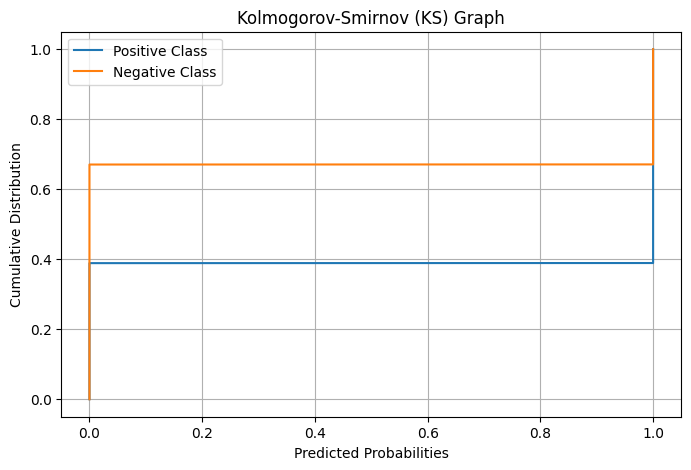

In [ ]:
# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

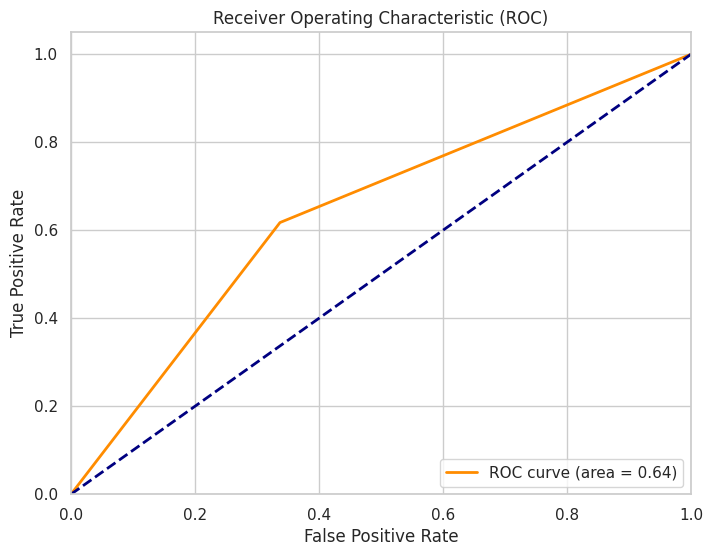

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 6️⃣ XGBoost

##### 🏋️ Training...

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

xgb_classifier.fit(X_train, y_train)
xbg_predictions = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, xbg_predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6502


##### 🤔 Analyzing the model's classification report

In [ ]:
class_report = classification_report(y_test, xbg_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.49      0.66      0.56     44700
           1       0.78      0.65      0.71     85033

    accuracy                           0.65    129733
   macro avg       0.64      0.65      0.64    129733
weighted avg       0.68      0.65      0.66    129733



##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = xgb_classifier.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.3061
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


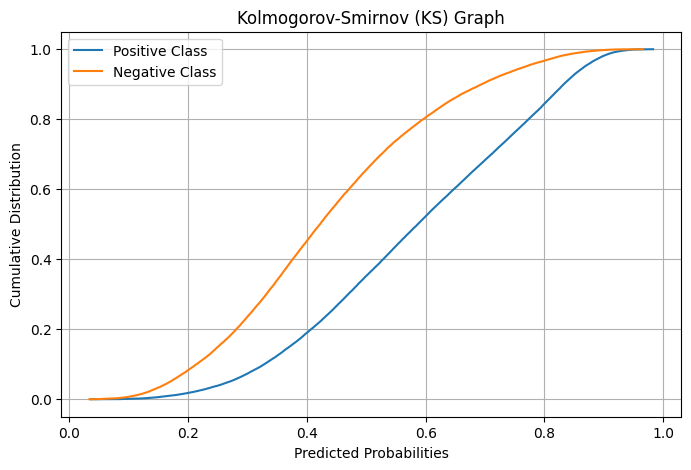

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

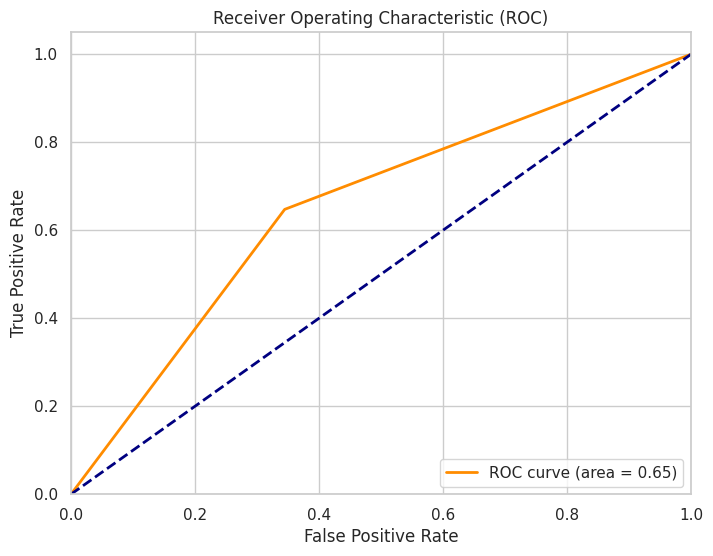

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, xbg_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#### 7️⃣ XGBoost Tuning

##### 🏋️ Training...

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,
    reg_lambda=1.5,
    reg_alpha=0.1,
    min_child_weight=5
)

xgb_classifier.fit(X_train, y_train)
xbg_predictions = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, xbg_predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6563


##### 🤔 Analyzing the model's classification report

In [ ]:
class_report = classification_report(y_test, xbg_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.50      0.67      0.57     44700
           1       0.79      0.65      0.71     85033

    accuracy                           0.66    129733
   macro avg       0.65      0.66      0.64    129733
weighted avg       0.69      0.66      0.66    129733



##### 💡 Kolmogorov-Smirnov (KS) test and graph

In [ ]:
predicted_probabilities = xgb_classifier.predict_proba(X_test)[:, 1]

In [ ]:
from scipy.stats import ks_2samp

ks_statistic, p_value = ks_2samp(predicted_probabilities[y_test == 1], predicted_probabilities[y_test == 0])

print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The distributions are significantly different (reject the null hypothesis).")
else:
    print("The distributions are not significantly different (fail to reject the null hypothesis).")

KS Statistic: 0.3204
P-value: 0.0000
The distributions are significantly different (reject the null hypothesis).


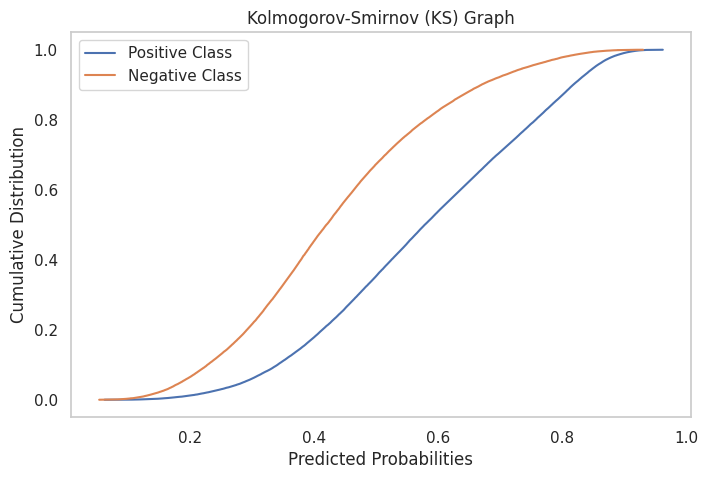

In [ ]:
# Calculate the cumulative distribution functions for both classes
sorted_positive_probs = np.sort(predicted_probabilities[y_test == 1])
cumulative_positive = np.arange(1, len(sorted_positive_probs) + 1) / len(sorted_positive_probs)

sorted_negative_probs = np.sort(predicted_probabilities[y_test == 0])
cumulative_negative = np.arange(1, len(sorted_negative_probs) + 1) / len(sorted_negative_probs)

# Plot the KS graph
plt.plot(sorted_positive_probs, cumulative_positive, label='Positive Class')
plt.plot(sorted_negative_probs, cumulative_negative, label='Negative Class')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Cumulative Distribution')
plt.title('Kolmogorov-Smirnov (KS) Graph')
plt.legend()
plt.grid()
plt.show()

##### 📈 AUC and ROC Curve

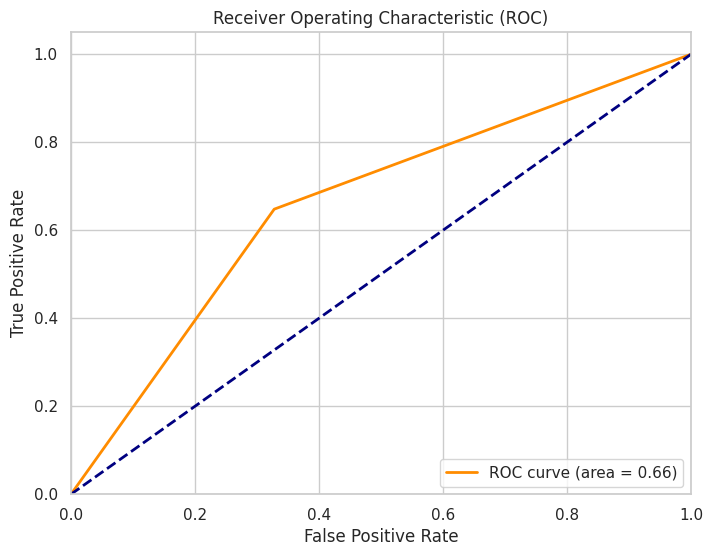

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, xbg_predictions)
roc_auc = auc(fpr, tpr)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### 😵‍💫 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion = confusion_matrix(y_test, xbg_predictions)

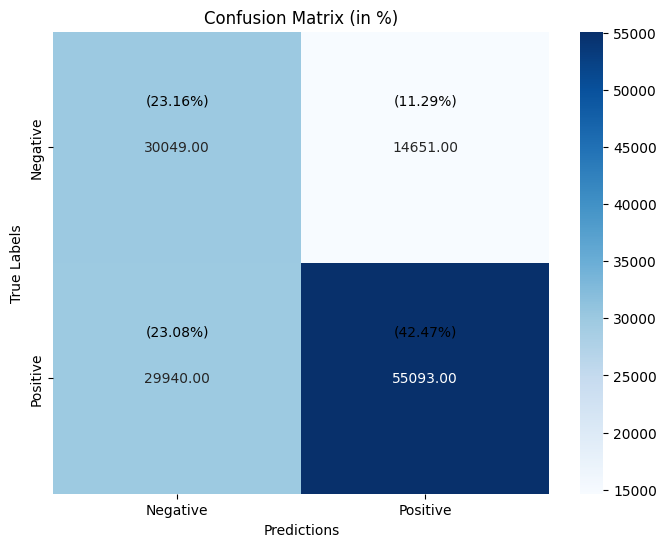

In [ ]:
total = np.sum(confusion)
confusion_percent = confusion / total * 100

labels = ['Negative', 'Positive']
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

for i in range(2):
    for j in range(2):
        ax.annotate(f'({confusion_percent[i, j]:.2f}%)',
                    xy=(j + 0.5, i + 0.3),
                    ha='center', va='center', color='black')

plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (in %)')
plt.show()

##### 🔹 Accuracy for each class

In [ ]:
accuracy_class_0 = accuracy_score(y_test[y_test == 0], xbg_predictions[y_test == 0])
accuracy_class_1 = accuracy_score(y_test[y_test == 1], xbg_predictions[y_test == 1])

print(f"Accuracy for Class 0: {accuracy_class_0:.4f}")
print(f"Accuracy for Class 1: {accuracy_class_1:.4f}")

Accuracy for Class 0: 0.6722
Accuracy for Class 1: 0.6479


#### 🪄 SHAP Analysis (Feature Importance)

SHAP analysis (SHapley Additive exPlanations) is a technique used to explain machine learning model predictions. It assigns a contribution to each feature in a prediction, showing how each feature influences the final outcome. The method is based on Shapley values from game theory, which determine the importance of each feature while considering all possible combinations of features.

In [ ]:
explainer = shap.Explainer(xgb_classifier, X_train)

In [ ]:
shap_values = explainer.shap_values(X_test)

100%|===================| 129726/129733 [50:42<00:00]        

##### 💟 Ranking the importance of features based on SHAP

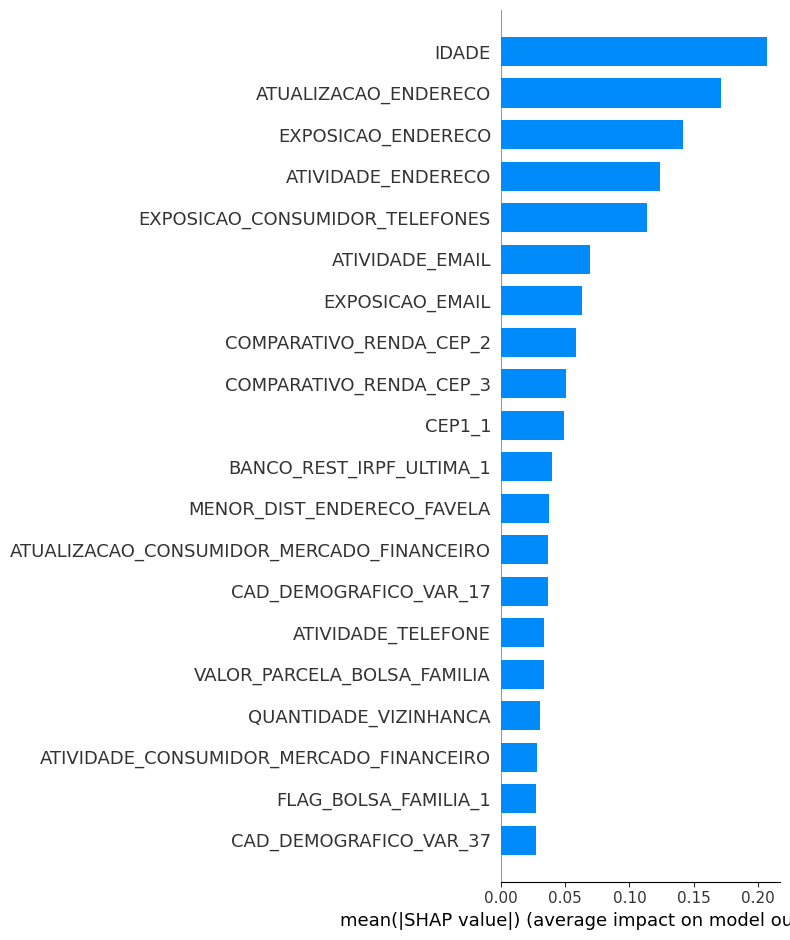

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

##### 💟 Visualizing contributions of individual features to specifics predictions

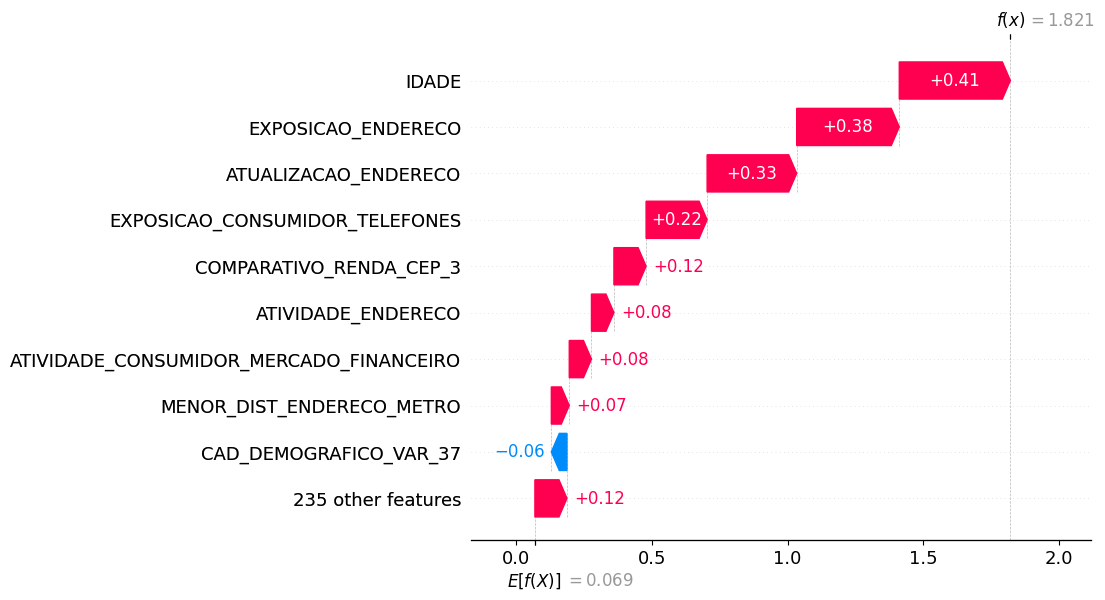

In [ ]:
feature_names = X_test.columns

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=feature_names)

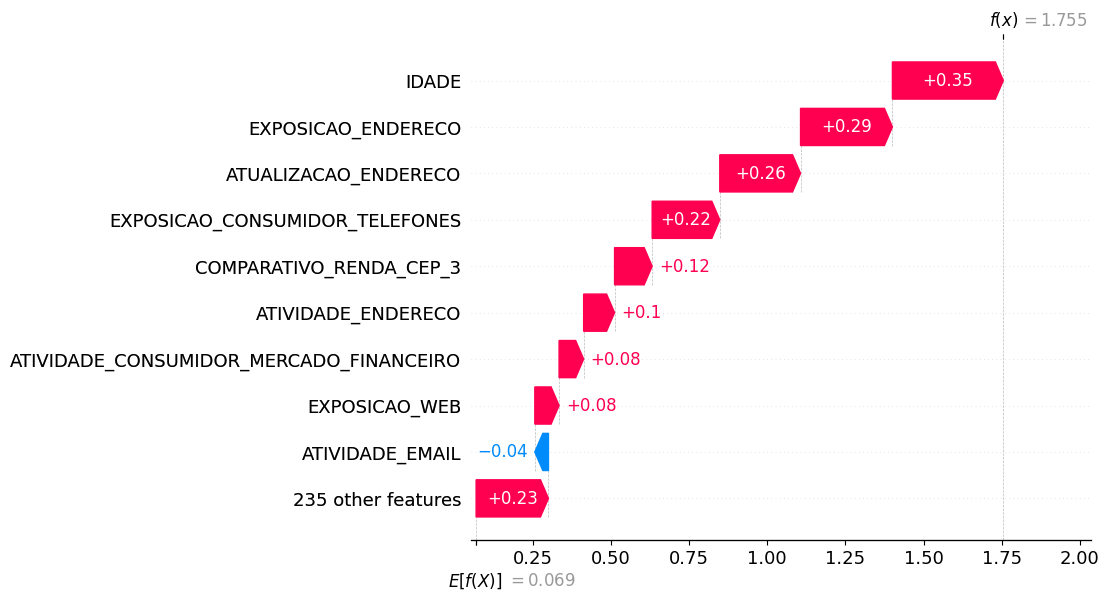

In [ ]:
feature_names = X_test.columns

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[1], feature_names=feature_names)

#### 💎 Conclusion

In the analysis of the results from our credit granting classification project, it is clear that various machine learning models have demonstrated promising outcomes.

Notably, the XGBoost algorithm, renowned for its proficiency in handling tabular data, exceeded expectations by achieving the highest Kolmogorov-Smirnov statistic (KS) of 0.32, accompanied by an accuracy of 0.66 and an area under the curve (AUC) of 0.66 after hyperparameter tuning. This outcome aligns with the industry's perception of XGBoost as a state-of-the-art choice for tabular data tasks.

However, it is crucial to emphasize that other models also delivered competitive results. For instance, our Random Forest Classifier achieved a KS of 0.23, an accuracy of 0.59, and an AUC of 0.62, showcasing its effectiveness in this context. Additionally, our Heterogeneous Classifiers Ensemble achieved a KS of 0.29, an accuracy of 0.63, and an AUC of 0.65, further highlighting the potential of diverse modeling approaches.

Furthermore, it is noteworthy how much the MLP model improved its performance after fine-tuning, going from a KS of nearly 0 to 0.28, which represents a impressive improvement and a good result.

In conclusion, while XGBoost emerged as the top-performing model, the success of our project is not solely attributed to a single algorithm. Instead, it underscores the importance of exploring various modeling approaches and leveraging fine-tuning techniques to unlock the full potential of machine learning in credit assessment.